# Imports

In [1]:
import scipy.io
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time # spooky

RNDS = 1389

# Data

In [2]:
mat_data = scipy.io.loadmat('./data/mnistAll.mat')
mnist_data = mat_data['mnist']

In [3]:
# load images
train_images = mnist_data['train_images'][0, 0].T.squeeze()
test_images = mnist_data['test_images'][0, 0].T.squeeze()
train_labels = mnist_data['train_labels'][0, 0].T.squeeze()
test_labels = mnist_data['test_labels'][0, 0].T.squeeze()
# find idxs that are of 3 and 7
train_filter = np.where((train_labels == 3) | (train_labels == 7))[0].squeeze()
test_filter = np.where((test_labels == 3) | (test_labels == 7))[0]

# filter only images and labels of 3 and 7
train_images = train_images[train_filter]
train_labels = train_labels[train_filter]
test_images = test_images[test_filter]
test_labels = test_labels[test_filter]

# split train into train and val
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=RNDS)

print(train_images.shape, val_images.shape, test_images.shape, train_labels.shape, val_labels.shape, test_labels.shape)

(9916, 28, 28) (2480, 28, 28) (2038, 28, 28) (9916,) (2480,) (2038,)


In [5]:
# scale inputs to be between 0 and 1
train_images = train_images.astype(float) / 255.0 # 255 because greyscale images
val_images = val_images.astype(float) / 255.0
test_images = test_images.astype(float) / 255.0

#print(train_images[0], val_images[0], test_images[0])

# scale classes to be 0 and 1 as well
train_labels = np.where(train_labels == 3, 0, 1)
val_labels = np.where(val_labels == 3, 0, 1)
test_labels = np.where(test_labels == 3, 0, 1)

## Gradient Descent

In [6]:
# sigmoid function
def sigma(x):
    return 1.0 / (1.0 + np.exp(-x))

# predict function
def predict(x, w):
    return sigma(np.dot(x, w))

# negative log likelihood
def NLL(y_pred, t):
    # clip the predicted values to avoid taking the logarithm of 0 or 1
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(t * np.log(y_pred) + (1 - t) * np.log(1 - y_pred))

# gradient with respect to weights
def gradient(x, y_pred, t):
    return np.dot(x.T, (y_pred - t)) / len(x)

def misclassification_rate(y_pred, t):
    # convert predictions to binary labels
    y_labels = (y_pred >= 0.5).astype(int)
    return np.mean(y_labels != t)

In [7]:
# gradient descent training with early stopping
def train(x, t, w, learning_rate, epochs, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        grad = gradient(x, y_pred, t)
        w -= learning_rate * grad
    
    return w, train_errors, val_errors, best_train_error, best_val_error

In [7]:
# set random seed for reproducibility
np.random.seed(RNDS)

# flatten and add a bias term to the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

train_images_bias = np.c_[np.ones((train_images_flat.shape[0], 1)), train_images_flat]
val_images_bias = np.c_[np.ones((val_images_flat.shape[0], 1)), val_images_flat]
test_images_bias = np.c_[np.ones((test_images_flat.shape[0], 1)), test_images_flat]

# random initial weights
w_init = np.random.randn(train_images_bias.shape[1])

learning_rates = [0.001, 0.01, 0.1]

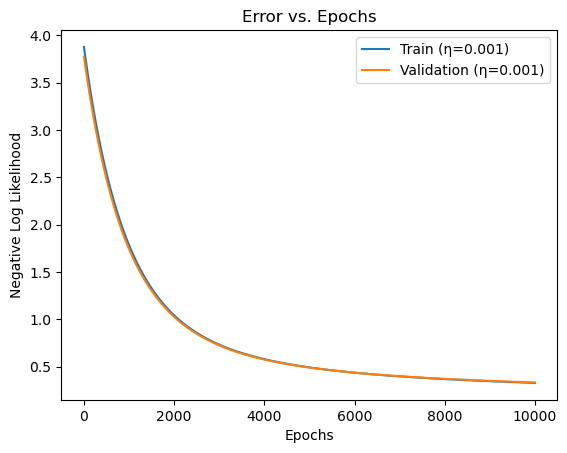

Best training error with learning rate 0.001: 0.32784502849393227
Best validation error with learning rate 0.001: 0.3327462085034984
Test error with learning rate 0.001: 0.34687764437703805
Training misclassification rate: 0.08884630899556273
Validation misclassification rate: 0.08629032258064516
Test misclassification rate: 0.08194308145240432
Training time for learning rate 0.001: 63.0069215297699 seconds


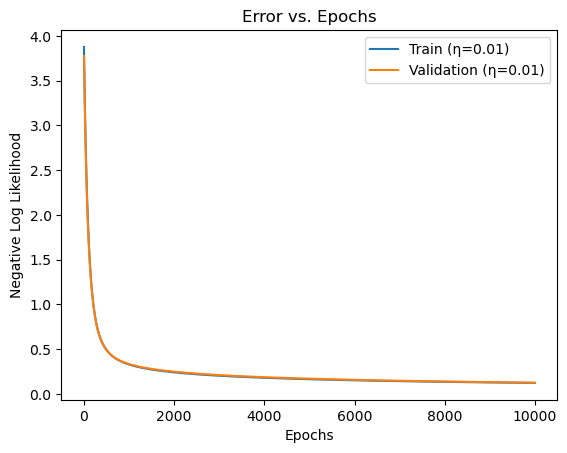

Best training error with learning rate 0.01: 0.12199507427493922
Best validation error with learning rate 0.01: 0.1244922575758461
Test error with learning rate 0.01: 0.1592400456497732
Training misclassification rate: 0.03227107704719645
Validation misclassification rate: 0.03467741935483871
Test misclassification rate: 0.03876349362119725
Training time for learning rate 0.01: 61.86552810668945 seconds


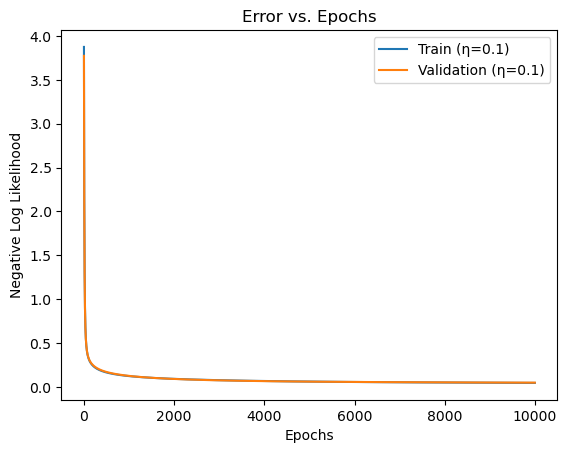

Best training error with learning rate 0.1: 0.044425517165283916
Best validation error with learning rate 0.1: 0.04758616564187317
Test error with learning rate 0.1: 0.07046595561086608
Training misclassification rate: 0.01300927793465107
Validation misclassification rate: 0.01532258064516129
Test misclassification rate: 0.020608439646712464
Training time for learning rate 0.1: 63.402435064315796 seconds


In [9]:
# training loop
for eta in learning_rates:
    start_time = time.time()
    
    w, train_errors, val_errors, best_train_error, best_val_error = train(train_images_bias, train_labels, w_init.copy(), eta, 10000, val_images_bias, val_labels)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    plt.plot(train_errors, label=f'Train (η={eta})')
    plt.plot(val_errors, label=f'Validation (η={eta})')
    plt.xlabel('Epochs')
    plt.ylabel('Negative Log Likelihood')
    plt.legend()
    plt.title('Error vs. Epochs')
    plt.show()
    
    y_train_pred = predict(train_images_bias, w)
    train_misclass_rate = misclassification_rate(y_train_pred, train_labels)
    
    y_val_pred = predict(val_images_bias, w)
    val_misclass_rate = misclassification_rate(y_val_pred, val_labels)
    
    y_test_pred = predict(test_images_bias, w)
    test_error = NLL(y_test_pred, test_labels)
    test_misclass_rate = misclassification_rate(y_test_pred, test_labels)
    
    print(f"Best training error with learning rate {eta}: {best_train_error}")
    print(f"Best validation error with learning rate {eta}: {best_val_error}")
    print(f"Test error with learning rate {eta}: {test_error}")
    print(f"Training misclassification rate: {train_misclass_rate}")
    print(f"Validation misclassification rate: {val_misclass_rate}")
    print(f"Test misclassification rate: {test_misclass_rate}")
    print(f"Training time for learning rate {eta}: {elapsed_time} seconds")

## Momentum

In [10]:
# redefine the gradient function to include momentum
def gradient(x, y_pred, t, prev_delta_w, alpha):
    grad = np.dot(x.T, (y_pred - t)) / len(x)
    delta_w = -grad + alpha * prev_delta_w
    return delta_w

In [11]:
# redefine the train function
def train(x, t, w, learning_rate, epochs, alpha, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    prev_delta_w = np.zeros_like(w)
    
    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        delta_w = gradient(x, y_pred, t, prev_delta_w, alpha)
        w += learning_rate * delta_w
        prev_delta_w = delta_w
    
    return w, train_errors, val_errors, best_train_error, best_val_error

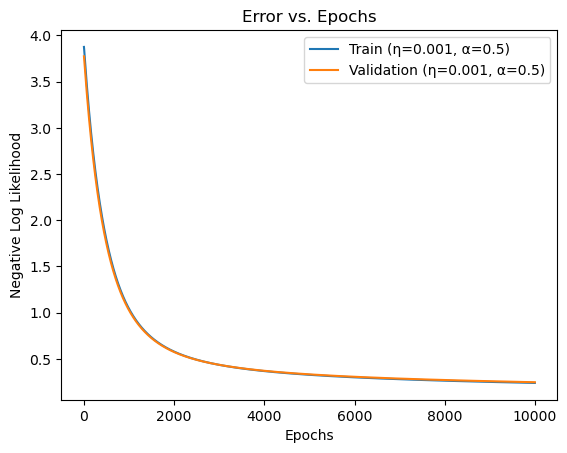

Best training error with (η=0.001, α=0.5): 0.24006703674663
Best validation error with (η=0.001, α=0.5): 0.24760487792550723
Test error with (η=0.001, α=0.5): 0.277105228955694
Training misclassification rate: 0.06524808390480032
Validation misclassification rate: 0.06491935483870968
Test misclassification rate: 0.06820412168792934
Training time (η=0.001, α=0.5): 61.51586961746216 seconds


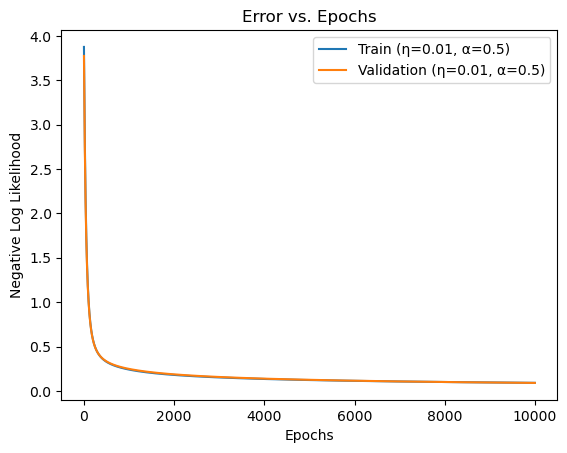

Best training error with (η=0.01, α=0.5): 0.09058181462715975
Best validation error with (η=0.01, α=0.5): 0.0895997830351151
Test error with (η=0.01, α=0.5): 0.12198842256652917
Training misclassification rate: 0.024203307785397338
Validation misclassification rate: 0.025806451612903226
Test misclassification rate: 0.030912659470068694
Training time (η=0.01, α=0.5): 62.342341899871826 seconds


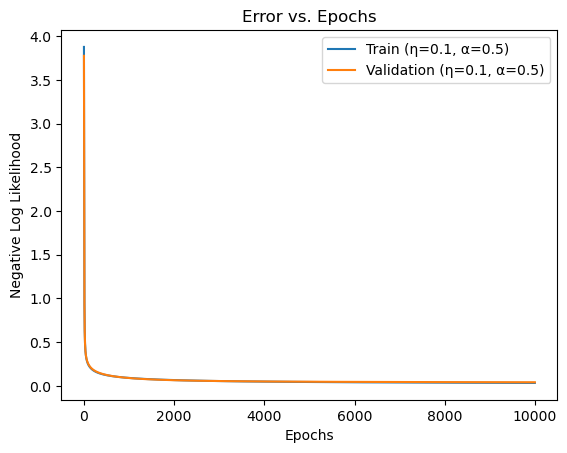

Best training error with (η=0.1, α=0.5): 0.03394503224581753
Best validation error with (η=0.1, α=0.5): 0.04149021740073238
Test error with (η=0.1, α=0.5): 0.06328058376527157
Training misclassification rate: 0.010891488503428802
Validation misclassification rate: 0.014516129032258065
Test misclassification rate: 0.019627085377821395
Training time (η=0.1, α=0.5): 63.28869962692261 seconds


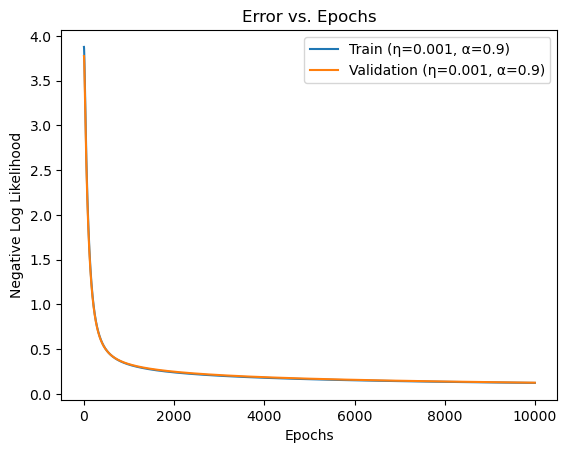

Best training error with (η=0.001, α=0.9): 0.12215741960882923
Best validation error with (η=0.001, α=0.9): 0.12468071881692333
Test error with (η=0.001, α=0.9): 0.15952237434311775
Training misclassification rate: 0.03227107704719645
Validation misclassification rate: 0.03467741935483871
Test misclassification rate: 0.03876349362119725
Training time (η=0.001, α=0.9): 62.692010164260864 seconds


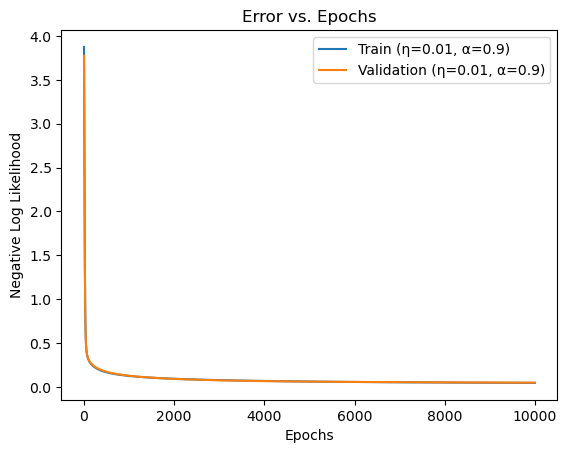

Best training error with (η=0.01, α=0.9): 0.04458831661301077
Best validation error with (η=0.01, α=0.9): 0.04772586704603971
Test error with (η=0.01, α=0.9): 0.07073025522909539
Training misclassification rate: 0.013110125050423558
Validation misclassification rate: 0.01532258064516129
Test misclassification rate: 0.020608439646712464
Training time (η=0.01, α=0.9): 62.99802041053772 seconds


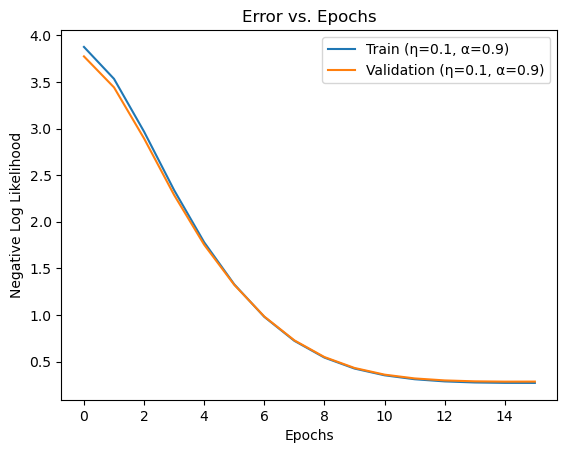

Best training error with (η=0.1, α=0.9): 0.27034154226835816
Best validation error with (η=0.1, α=0.9): 0.28424670283657844
Test error with (η=0.1, α=0.9): 0.34400948091877265
Training misclassification rate: 0.058592174263816056
Validation misclassification rate: 0.06129032258064516
Test misclassification rate: 0.06035328753680078
Training time (η=0.1, α=0.9): 0.09304594993591309 seconds


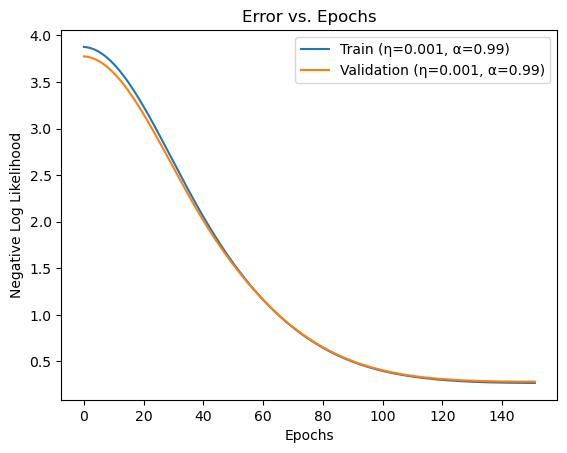

Best training error with (η=0.001, α=0.99): 0.2691595372012836
Best validation error with (η=0.001, α=0.99): 0.2829088469071293
Test error with (η=0.001, α=0.99): 0.3382220305392126
Training misclassification rate: 0.05788624445340863
Validation misclassification rate: 0.06088709677419355
Test misclassification rate: 0.061334641805691856
Training time (η=0.001, α=0.99): 0.9085612297058105 seconds


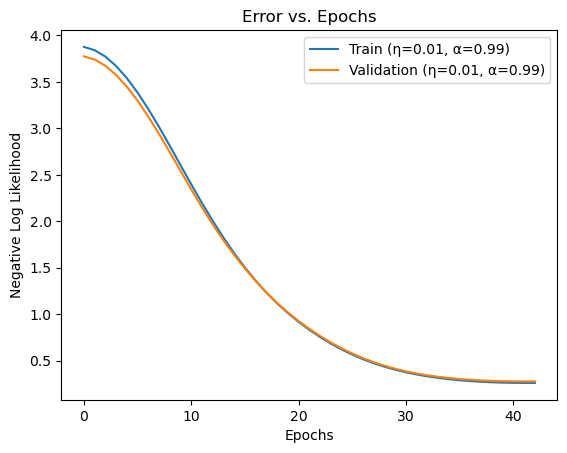

Best training error with (η=0.01, α=0.99): 0.2609226328459017
Best validation error with (η=0.01, α=0.99): 0.2770668141740353
Test error with (η=0.01, α=0.99): 0.3409749268298889
Training misclassification rate: 0.050322710770471964
Validation misclassification rate: 0.05241935483870968
Test misclassification rate: 0.05299313052011776
Training time (η=0.01, α=0.99): 0.2447197437286377 seconds


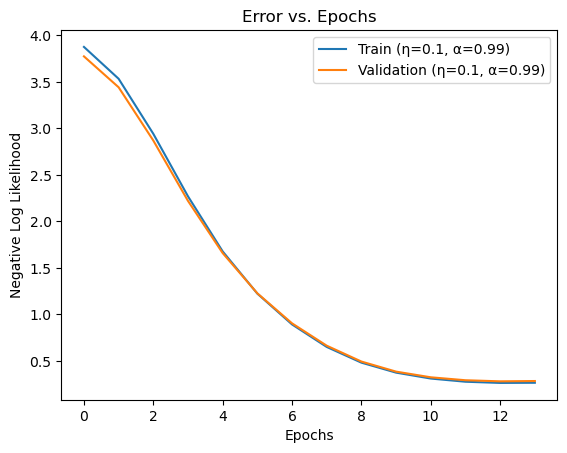

Best training error with (η=0.1, α=0.99): 0.2631245716818635
Best validation error with (η=0.1, α=0.99): 0.2802048654268888
Test error with (η=0.1, α=0.99): 0.35678798711300497
Training misclassification rate: 0.04739814441306978
Validation misclassification rate: 0.04838709677419355
Test misclassification rate: 0.04857703631010795
Training time (η=0.1, α=0.99): 0.07988929748535156 seconds


In [12]:
# training loop
momentums = [0.5, 0.9, 0.99]

for alpha in momentums:
    for eta in learning_rates:
        start_time = time.time()
    
        w, train_errors, val_errors, best_train_error, best_val_error = train(train_images_bias, train_labels, w_init.copy(), eta, 10000, alpha, val_images_bias, val_labels)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
    
        plt.plot(train_errors, label=f'Train (η={eta}, α={alpha})')
        plt.plot(val_errors, label=f'Validation (η={eta}, α={alpha})')
        plt.xlabel('Epochs')
        plt.ylabel('Negative Log Likelihood')
        plt.legend()
        plt.title('Error vs. Epochs')
        plt.show()
    
        y_train_pred = predict(train_images_bias, w)
        train_misclass_rate = misclassification_rate(y_train_pred, train_labels)
    
        y_val_pred = predict(val_images_bias, w)
        val_misclass_rate = misclassification_rate(y_val_pred, val_labels)
    
        y_test_pred = predict(test_images_bias, w)
        test_error = NLL(y_test_pred, test_labels)
        test_misclass_rate = misclassification_rate(y_test_pred, test_labels)
    
        print(f"Best training error with (η={eta}, α={alpha}): {best_train_error}")
        print(f"Best validation error with (η={eta}, α={alpha}): {best_val_error}")
        print(f"Test error with (η={eta}, α={alpha}): {test_error}")
        print(f"Training misclassification rate: {train_misclass_rate}")
        print(f"Validation misclassification rate: {val_misclass_rate}")
        print(f"Test misclassification rate: {test_misclass_rate}")
        print(f"Training time (η={eta}, α={alpha}): {elapsed_time} seconds")

## Weight Decay

In [22]:
# redefine gradient
def gradient(x, y_pred, t, w, prev_delta_w, lambda_value, alpha):
    nll_gradient = np.dot(x.T, (y_pred - t)) / len(x)
    regularization_gradient = lambda_value * w / x.shape[1]
    total_gradient = nll_gradient + regularization_gradient
    delta_w = -total_gradient + alpha * prev_delta_w # applying momentum
    
    return delta_w

In [11]:
def train(x, t, w, learning_rate, epochs, lambda_value, alpha, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    prev_delta_w = np.zeros_like(w)
    
    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        delta_w = gradient(x, y_pred, t, w, prev_delta_w, lambda_value, alpha)
        w += learning_rate * delta_w
        prev_delta_w = delta_w
    
    return w, train_errors, val_errors, best_train_error, best_val_error

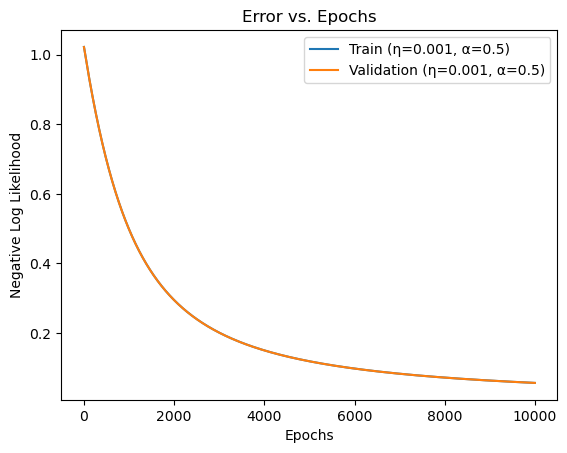

Best training error with (η=0.001, α=0.5): 0.056807249626117884
Best validation error with (η=0.001, α=0.5): 0.05677072688495529
Test error with (η=0.001, α=0.5): 0.056830905934952214
Training misclassification rate: 0.0
Validation misclassification rate: 0.0
Test misclassification rate: 0.0
Training time (η=0.001, α=0.5): 92.77969193458557 seconds


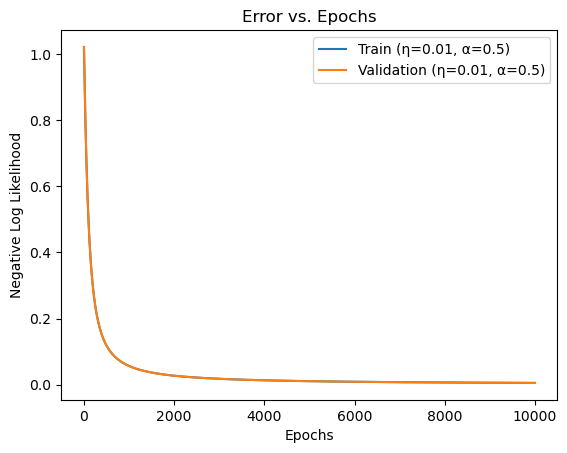

Best training error with (η=0.01, α=0.5): 0.0054271148061975655
Best validation error with (η=0.01, α=0.5): 0.005423688785800923
Test error with (η=0.01, α=0.5): 0.005429298736945215
Training misclassification rate: 0.0
Validation misclassification rate: 0.0
Test misclassification rate: 0.0
Training time (η=0.01, α=0.5): 90.84272027015686 seconds


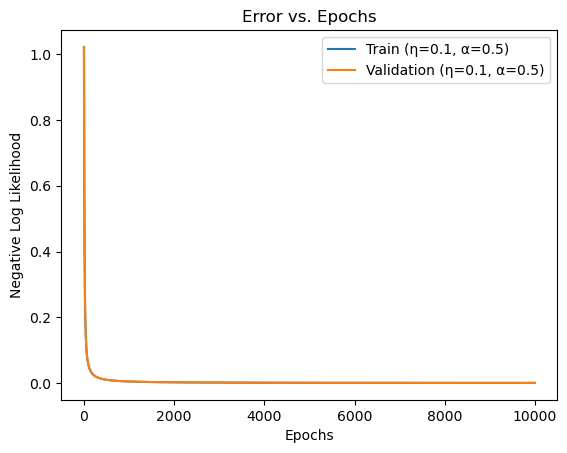

Best training error with (η=0.1, α=0.5): 0.0010403300536512951
Best validation error with (η=0.1, α=0.5): 0.0010398246410841412
Test error with (η=0.1, α=0.5): 0.0010406771380106574
Training misclassification rate: 0.0
Validation misclassification rate: 0.0
Test misclassification rate: 0.0
Training time (η=0.1, α=0.5): 87.22539472579956 seconds


In [12]:
# training loop
alpha = 0.5 # based on previous experiments
lambda_value = 0.1

for eta in learning_rates:
    start_time = time.time()

    w, train_errors, val_errors, best_train_error, best_val_error = train(train_images_bias, train_labels, w_init.copy(), eta, 10000, lambda_value, alpha, val_images_bias, val_labels)
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    plt.plot(train_errors, label=f'Train (η={eta}, α={alpha})')
    plt.plot(val_errors, label=f'Validation (η={eta}, α={alpha})')
    plt.xlabel('Epochs')
    plt.ylabel('Negative Log Likelihood')
    plt.legend()
    plt.title('Error vs. Epochs')
    plt.show()

    y_train_pred = predict(train_images_bias, w)
    train_misclass_rate = misclassification_rate(y_train_pred, train_labels)

    y_val_pred = predict(val_images_bias, w)
    val_misclass_rate = misclassification_rate(y_val_pred, val_labels)

    y_test_pred = predict(test_images_bias, w)
    test_error = NLL(y_test_pred, test_labels)
    test_misclass_rate = misclassification_rate(y_test_pred, test_labels)

    print(f"Best training error with (η={eta}, α={alpha}): {best_train_error}")
    print(f"Best validation error with (η={eta}, α={alpha}): {best_val_error}")
    print(f"Test error with (η={eta}, α={alpha}): {test_error}")
    print(f"Training misclassification rate: {train_misclass_rate}")
    print(f"Validation misclassification rate: {val_misclass_rate}")
    print(f"Test misclassification rate: {test_misclass_rate}")
    print(f"Training time (η={eta}, α={alpha}): {elapsed_time} seconds")

## Newton Method

In [23]:
def hessian(X, y_pred, alpha):
    R = np.diagflat(y_pred * (1 - y_pred))
    H = X.T @ R @ X + alpha * np.eye(X.shape[1])
    return H

In [24]:
# redefine train
def train(x, t, w, learning_rate, epochs, lambda_value, alpha, x_val=None, t_val=None):
    train_errors = []
    val_errors = []

    best_train_error = float('inf')
    best_val_error = float('inf')

    prev_delta_w = np.zeros_like(w)

    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
                
        grad = gradient(x, y_pred, t, w, prev_delta_w, lambda_value, alpha)
        H = hessian(x, y_pred, alpha)
        delta_w = -np.linalg.inv(H) @ grad
        w -= learning_rate * delta_w
        prev_delta_w = delta_w

    return w, train_errors, val_errors, best_train_error, best_val_error

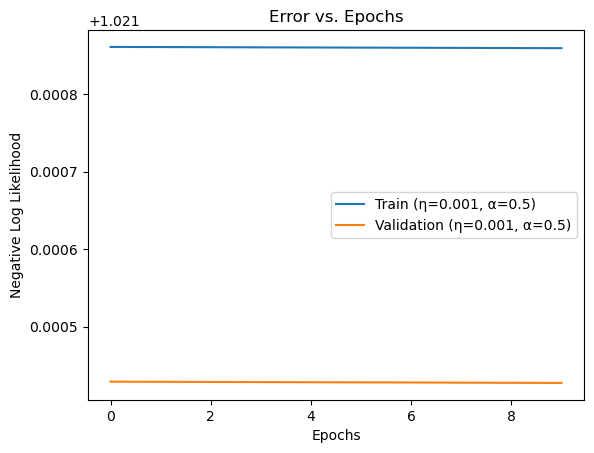

Best training error with (η=0.001, α=0.5): 1.021859212082634
Best validation error with (η=0.001, α=0.5): 1.021427290459327
Test error with (η=0.001, α=0.5): 1.0222312885561937
Training misclassification rate: 1.0
Validation misclassification rate: 1.0
Test misclassification rate: 1.0
Training time (η=0.001, α=0.5): 15.567757606506348 seconds


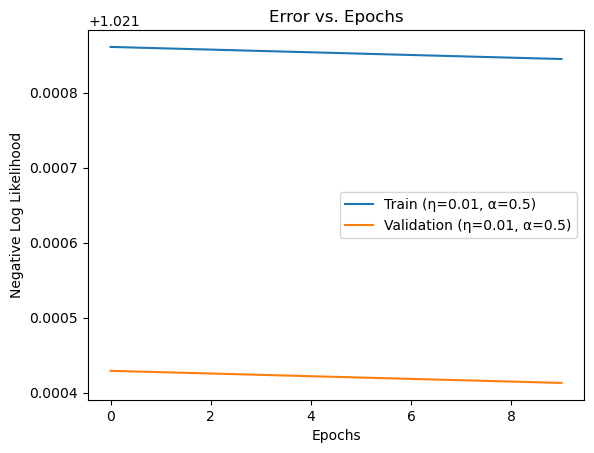

Best training error with (η=0.01, α=0.5): 1.0218446878451055
Best validation error with (η=0.01, α=0.5): 1.0214127747578008
Test error with (η=0.01, α=0.5): 1.0222151430314026
Training misclassification rate: 1.0
Validation misclassification rate: 1.0
Test misclassification rate: 1.0
Training time (η=0.01, α=0.5): 15.422025442123413 seconds


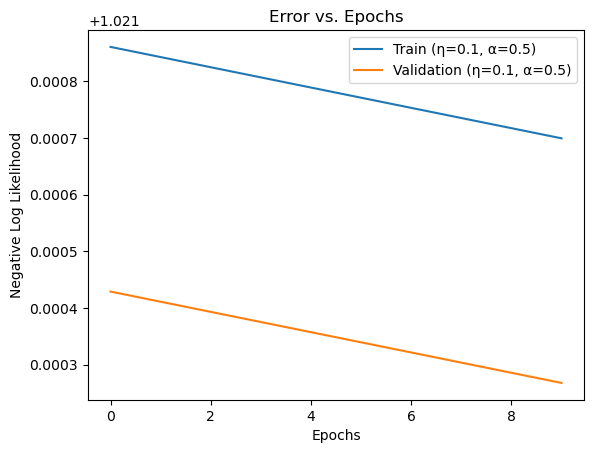

Best training error with (η=0.1, α=0.5): 1.0216994623063094
Best validation error with (η=0.1, α=0.5): 1.0212676345694938
Test error with (η=0.1, α=0.5): 1.0220537087360964
Training misclassification rate: 1.0
Validation misclassification rate: 1.0
Test misclassification rate: 1.0
Training time (η=0.1, α=0.5): 14.357025623321533 seconds


In [26]:
# training loop
alpha = 0.5 # based on previous experiments
lambda_value = 0.1

for eta in learning_rates:
    start_time = time.time()

    w, train_errors, val_errors, best_train_error, best_val_error = train(train_images_bias, train_labels, w_init.copy(), eta, 10, lambda_value, alpha, val_images_bias, val_labels)
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    plt.plot(train_errors, label=f'Train (η={eta}, α={alpha})')
    plt.plot(val_errors, label=f'Validation (η={eta}, α={alpha})')
    plt.xlabel('Epochs')
    plt.ylabel('Negative Log Likelihood')
    plt.legend()
    plt.title('Error vs. Epochs')
    plt.show()

    y_train_pred = predict(train_images_bias, w)
    train_misclass_rate = misclassification_rate(y_train_pred, train_labels)

    y_val_pred = predict(val_images_bias, w)
    val_misclass_rate = misclassification_rate(y_val_pred, val_labels)

    y_test_pred = predict(test_images_bias, w)
    test_error = NLL(y_test_pred, test_labels)
    test_misclass_rate = misclassification_rate(y_test_pred, test_labels)

    print(f"Best training error with (η={eta}, α={alpha}): {best_train_error}")
    print(f"Best validation error with (η={eta}, α={alpha}): {best_val_error}")
    print(f"Test error with (η={eta}, α={alpha}): {test_error}")
    print(f"Training misclassification rate: {train_misclass_rate}")
    print(f"Validation misclassification rate: {val_misclass_rate}")
    print(f"Test misclassification rate: {test_misclass_rate}")
    print(f"Training time (η={eta}, α={alpha}): {elapsed_time} seconds")

## Line Search

In [18]:
# use the original gradient function
def gradient(x, y_pred, t):
    return np.dot(x.T, (y_pred - t)) / len(x)

# please note that this is a very naive implementation of line search =(
def line_search(w, d, x, t, init_gamma=0.001, max_iters=100, gamma_scale=1.1):
    best_gamma = init_gamma
    best_error = float('inf')
    
    gamma = init_gamma
    for i in range(max_iters):
        w_try = w + gamma * d
        y_pred = predict(x, w_try)
        error = NLL(y_pred, t)
        
        if error < best_error:
            best_error = error
            best_gamma = gamma
        else:
            break
        
        gamma *= gamma_scale
    
    return best_gamma

In [19]:
def train(x, t, w, learning_rate, epochs, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        grad = gradient(x, y_pred, t)
        optimal_lr = line_search(w, -grad, x, t)
        w -= optimal_lr * grad
    
    return w, train_errors, val_errors, best_train_error, best_val_error

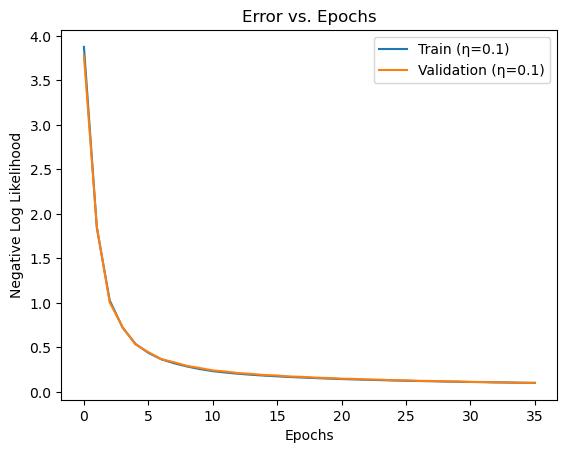

Best training error with learning rate 0.1: 0.10115969193650216
Best validation error with learning rate 0.1: 0.10262695280237122
Test error with learning rate 0.1: 0.1319526758982514
Training misclassification rate: 0.02581686163775716
Validation misclassification rate: 0.028629032258064516
Test misclassification rate: 0.03189401373895977
Training time for learning rate 0.1: 9.224005460739136 seconds


In [21]:
# training loop
start_time = time.time()

w, train_errors, val_errors, best_train_error, best_val_error = train(train_images_bias, train_labels, w_init.copy(), eta, 224, val_images_bias, val_labels)

end_time = time.time()
elapsed_time = end_time - start_time

plt.plot(train_errors, label=f'Train (η={eta})')
plt.plot(val_errors, label=f'Validation (η={eta})')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Error vs. Epochs')
plt.show()

y_train_pred = predict(train_images_bias, w)
train_misclass_rate = misclassification_rate(y_train_pred, train_labels)

y_val_pred = predict(val_images_bias, w)
val_misclass_rate = misclassification_rate(y_val_pred, val_labels)

y_test_pred = predict(test_images_bias, w)
test_error = NLL(y_test_pred, test_labels)
test_misclass_rate = misclassification_rate(y_test_pred, test_labels)

print(f"Best training error with learning rate {eta}: {best_train_error}")
print(f"Best validation error with learning rate {eta}: {best_val_error}")
print(f"Test error with learning rate {eta}: {test_error}")
print(f"Training misclassification rate: {train_misclass_rate}")
print(f"Validation misclassification rate: {val_misclass_rate}")
print(f"Test misclassification rate: {test_misclass_rate}")
print(f"Training time for learning rate {eta}: {elapsed_time} seconds")

## Conjugate Gradient Descent